<h2 style="text-align: center;">Generalized method of moments</h2>


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize
from scipy.special import comb  # For binomial coefficients


In [17]:
class Vasicek:
    def __init__(self, kappa, theta, sigma):
        """
        Initialize the parameters for the Vasicek model.
        
        :param kappa: Speed of mean reversion
        :param theta: Long-term mean level
        :param sigma: Volatility of the process
        """
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma

    def generate(self, X0, T, N, n):
        """
        Generate N trajectories of the Vasicek process on the interval [0, T] with a time step of T/n.
        
        :param X0: Initial value of the process
        :param T: The total time period
        :param N: Number of trajectories to generate
        :param n: Number of discretization steps (so time step is T/n)
        
        :return: Array of N trajectories discretized over the interval [0, T]
        """
        dt = T / n  # Adjusted time step for the interval [0, T]
        trajectories = np.zeros((N, n))  # Matrix to store the trajectories
        trajectories[:, 0] = X0  # Initialize all trajectories at X0

        for i in range(1, n):
            # Generate standard normal noise
            Z = np.random.randn(N)  # Standard normal random variables for each trajectory
            # Update the process value according to the Vasicek model
            trajectories[:, i] = (
                trajectories[:, i - 1] * np.exp(-self.kappa * dt)
                + self.theta * (1 - np.exp(-self.kappa * dt))
                + self.sigma * np.sqrt((1 - np.exp(-2 * self.kappa * dt)) / (2 * self.kappa)) * Z
            )

        return trajectories


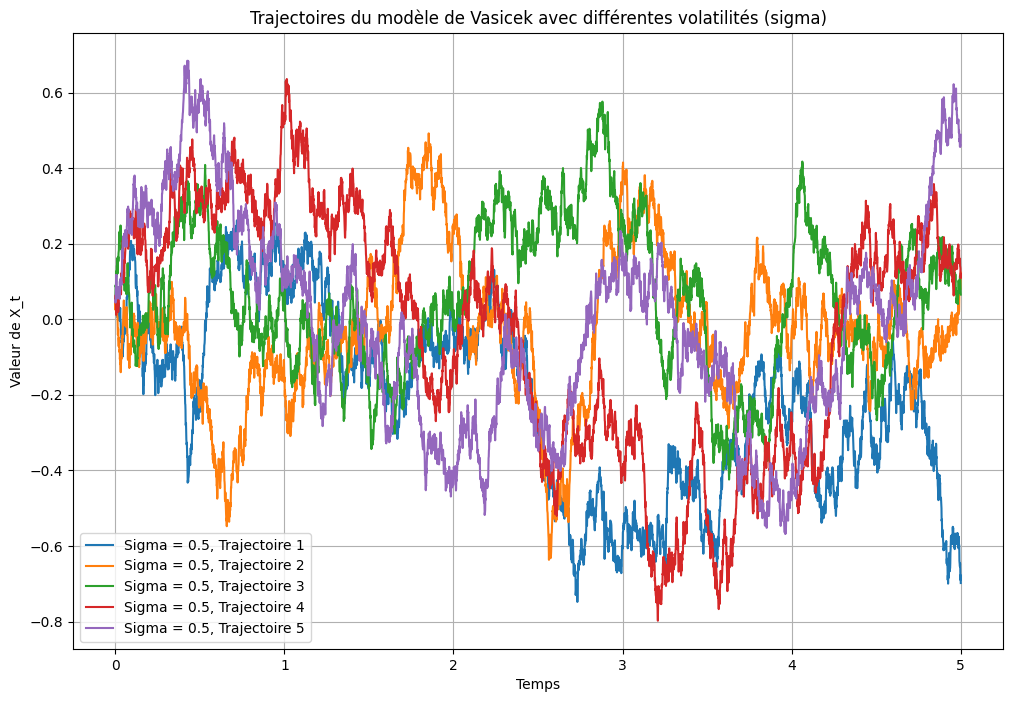

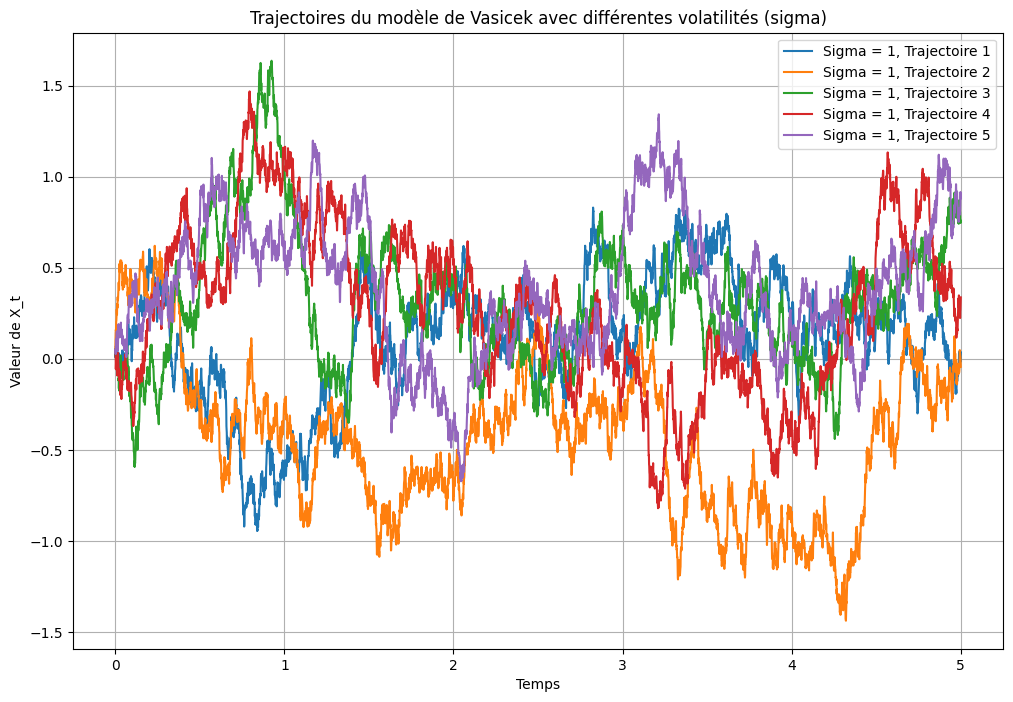

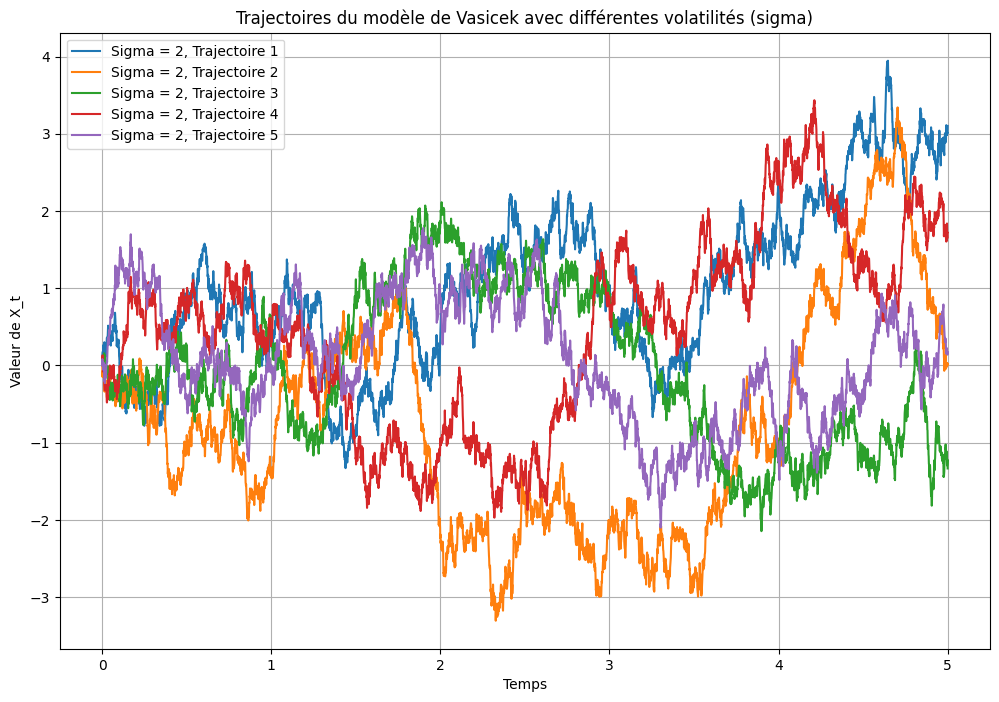

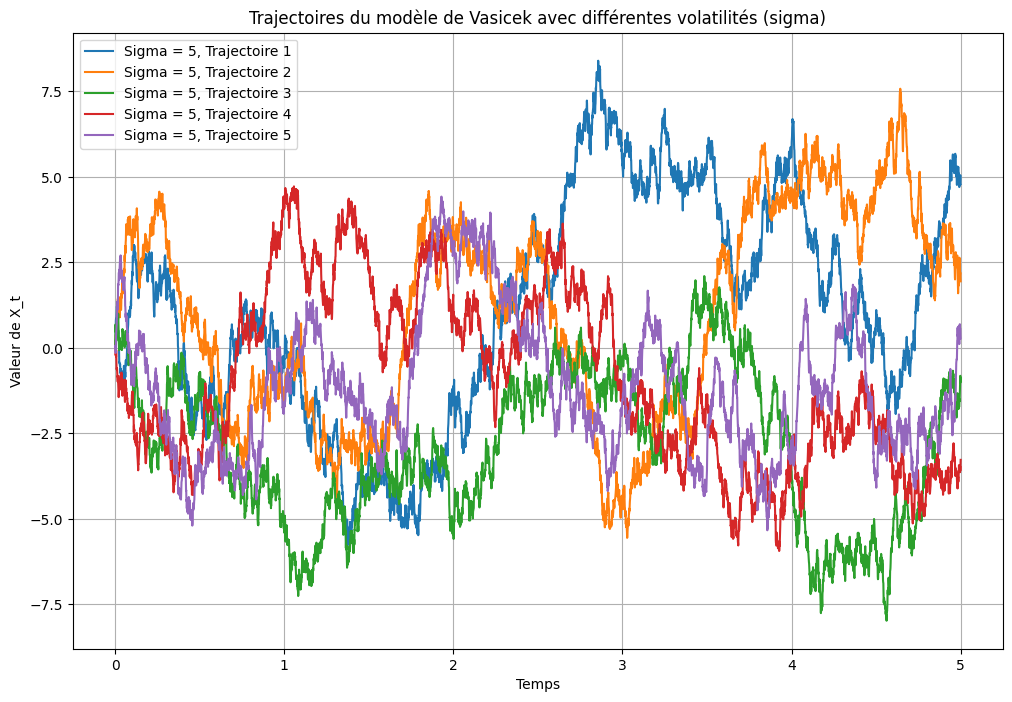

In [18]:


# Paramètres du modèle de Vasicek
kappa = 1  # vitesse de réversion vers la moyenne
theta = 0  # niveau de la moyenne à long terme
X0 = 0.05  # valeur initiale
N = 5  # nombre de trajectoires à générer
n = 5000  # nombre de pas de discrétisation
T = 5  # durée totale

# Liste des valeurs de sigma
sigma_values = [0.5, 1, 2, 5]

# Créer un objet de la classe Vasicek et générer les trajectoires pour chaque valeur de sigma
for sigma in sigma_values:
    # Créer un objet avec la valeur de sigma courante
    plt.figure(figsize=(12, 8))
    vasicek_process = Vasicek(kappa, theta, sigma)
    
    # Générer les trajectoires
    trajectories = vasicek_process.generate(X0, T, N, n)  # Correction: Pass X0, T, N, n
    
    # Affichage des trajectoires générées pour chaque sigma
    time = np.linspace(0, T, n)
    for i in range(N):
        plt.plot(time, trajectories[i], label=f"Sigma = {sigma}, Trajectoire {i+1}")
    
    plt.title("Trajectoires du modèle de Vasicek avec différentes volatilités (sigma)")
    plt.xlabel("Temps")
    plt.ylabel("Valeur de X_t")
    plt.legend()
    plt.grid(True)
    plt.show()


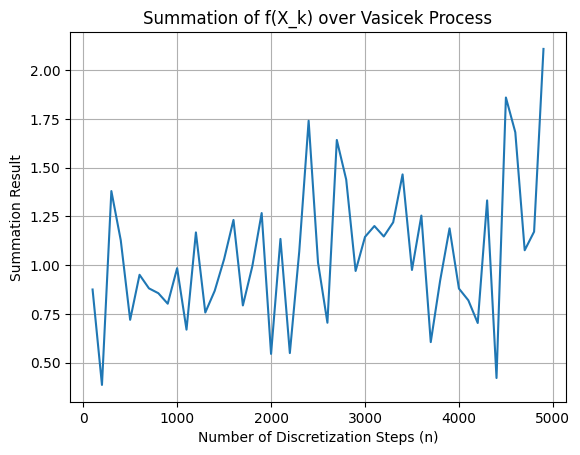

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_sum(n, f, kappa=1, theta=1, sigma=0.5, X0=1,T=5):
    """
    Calculate the summation: (1/n) * sum_{k=0}^n f(X_k), where X_k is generated by the Vasicek model.
    
    :param n: Number of steps in the discretization
    :param f: Function to apply to each X_k
    :param kappa: Speed of mean reversion
    :param theta: Long-term mean level
    :param sigma: Volatility
    :param X0: Initial value of the process
    :return: The computed summation
    """
    vasicek_process = Vasicek(kappa, theta, sigma)
      # Time horizon

    # Generate one trajectory
    trajectories = vasicek_process.generate(X0, T, 1, n)  # One trajectory, n steps
    res = 0
    trajectory = trajectories[0]  # Take the first trajectory
    res +=(1 / n) * sum(f(x) for x in trajectory)
    # Compute the summation
    return res

# Define the function to apply to each X_k
f = lambda x: x**2  # Example: Square of each value

n_values = range(100, 5000, 100)  # Range of n values for testing
Y = [calculate_sum(n, f) for n in n_values]  # Compute the result for each n

# Plot the results
plt.plot(n_values, Y)
plt.xlabel("Number of Discretization Steps (n)")
plt.ylabel("Summation Result")
plt.title("Summation of f(X_k) over Vasicek Process")
plt.grid(True)
plt.show()

In [20]:
def expected_value_vasicek(power, theta, sigma, kappa):
    """
    Compute the expected value of the Vasicek process at X_n using the closed-form formula.
    
    :param n: Number of steps in the discretization
    :param theta: Long-term mean level
    :param sigma: Volatility
    :param kappa: Speed of mean reversion
    :return: The theoretical expected value
    """
    expected_sum = 0
    for k in range(power + 1):
        # Binomial coefficient
        binom_coeff = comb(power, k)
        
        # Factor for theta and sigma
        theta_factor = theta**(power - k)
        sigma_factor = sigma**k / (2 * kappa)**(k//2)
        
        # Expectation of Z^k
        if k % 2 == 0:  # Even powers of Z
            m = k // 2
            # For even k, the expectation of Z^{2m} is (2m-1)!! = (2m-1)*(2m-3)*...*1
            z_expectation = math.factorial(2 * m) // (2**m * math.factorial(m))  # Double factorial calculation
        else:  # Odd powers of Z
            z_expectation = 0
        
        # Add to the summation
        expected_sum += binom_coeff * theta_factor * sigma_factor * z_expectation
    
    return expected_sum


# Parameters for Vasicek
theta = 0
sigma = 1
kappa = 1
n = 2

# Compute theoretical expectation
true_value = expected_value_vasicek(n, theta, sigma, kappa)
print("Theoretical Expected Value:", true_value)


Theoretical Expected Value: 0.5


Theoretical Expected Value: 1.125
Average of computed Summation: 0.6097381010247851


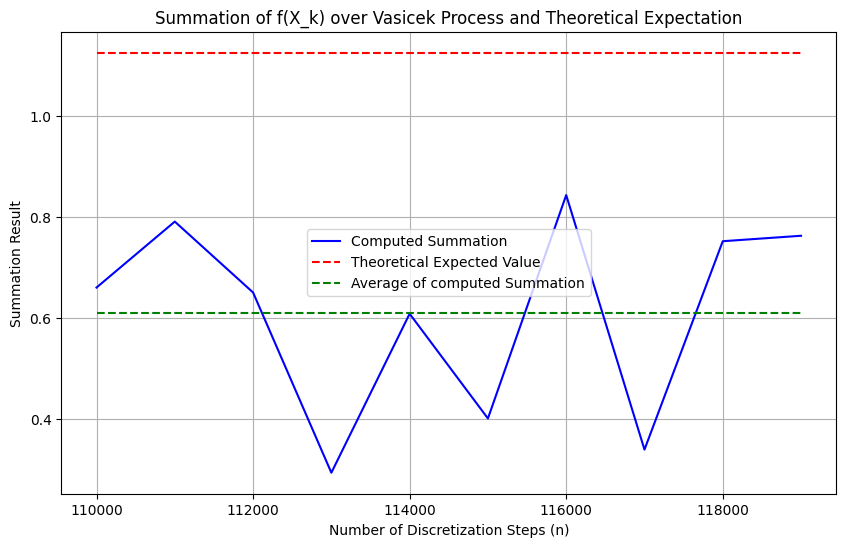

In [25]:

# Example parameters
kappa = 1  # Speed of mean reversion
theta = 1  # Long-term mean level
sigma = 0.5  # Volatility
X0 = 0.05  # Initial value
N = 1  # Only 1 trajectory for the summation computation
n_values = range(110000, 120000, 1000)  # Range of n values for testing
n = 2 # Choose a large n for comparison

# Define the function to apply to each X_k
f = lambda x: x**n# Example: x^3

# Compute the summation for each value of n
Y = [calculate_sum(n, f, kappa=kappa, theta=theta, sigma=sigma, X0=X0) for n in n_values]
y0 = sum(Y)/len(Y)
# Compute the true value of the expectation
true_value = expected_value_vasicek(n, theta, sigma, kappa)
Y0 = [true_value for _ in n_values]  # Create a constant list for the theoretical expected value
Y1 = [y0 for _ in n_values]
# Print the theoretical expected value
print("Theoretical Expected Value:", true_value)
print("Average of computed Summation:", y0)
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_values, Y, label="Computed Summation", color="blue")
plt.plot(n_values, Y0, label="Theoretical Expected Value", color="red", linestyle="--")
plt.plot(n_values, Y1, label="Average of computed Summation", color="green", linestyle="--")
plt.xlabel("Number of Discretization Steps (n)")
plt.ylabel("Summation Result")
plt.title("Summation of f(X_k) over Vasicek Process and Theoretical Expectation")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_182581/3035828491.py:48: OptimizeWarning: Unknown solver options: xatol, maxfev
  res = minimize(matrix_calculator, initial_guess, method='BFGS',


Iteration: 1
Z (theoretical): [0.         0.10416667 0.        ]
Y (empirical): [-0.143007    0.13340296 -0.20378904]
Z_true: [0.    0.125 0.   ]
Difference (Z - Z_true): [ 0.         -0.02083333  0.        ]
Norm is  0.06205158348599027
Iteration: 11
Z (theoretical): [0.05609961 0.01584924 0.0023143 ]
Y (empirical): [0.14419069 0.00957746 0.00332415]
Z_true: [0.    0.125 0.   ]
Difference (Z - Z_true): [ 0.05609961 -0.10915076  0.0023143 ]
Norm is  0.03412436685575776
Iteration: 21
Z (theoretical): [0.00164657 0.10008123 0.00049436]
Y (empirical): [-0.2051566   0.05102902  0.00050208]
Z_true: [0.    0.125 0.   ]
Difference (Z - Z_true): [ 0.00164657 -0.02491877  0.00049436]
Norm is  0.04756118842918381
Iteration: 31
Z (theoretical): [2.00877897e-04 1.03663076e-01 6.24708456e-05]
Y (empirical): [-0.48903001  0.22293104  0.10216587]
Z_true: [0.    0.125 0.   ]
Difference (Z - Z_true): [ 2.00877897e-04 -2.13369245e-02  6.24708456e-05]
Norm is  0.2591787069086495
Iteration: 41
Z (theoreti

/home/hassene/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


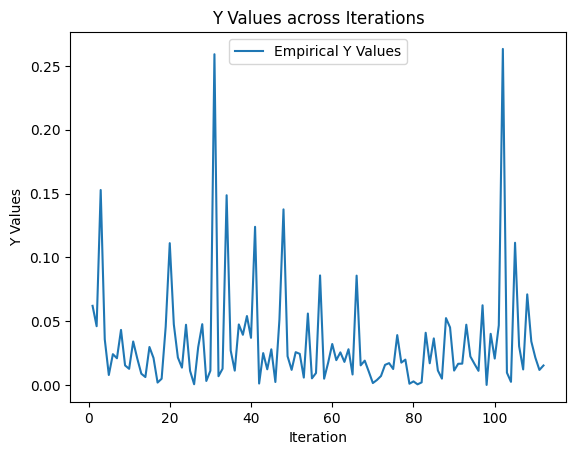

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# Number of moments to generate
n = 3
# True values for parameters
theta_true = 0
sigma_true = 0.5
kappa_true = 1
L = []
# Generate synthetic data
Z_true = np.zeros(n)
for i in range(n):
    Z_true[i] = expected_value_vasicek(i + 1, theta_true, sigma_true, kappa_true)

def parameter_estimator():
    """Generalized Method of Moments estimator for the Vasicek model."""
    def matrix_calculator(params):
        theta, sigma, kappa = params
        # Initialize Z and Y arrays
        Z = np.zeros(n)
        Y = np.zeros(n)
        
        # Compute Z values
        for i in range(n):
            Z[i] = expected_value_vasicek(i + 1, theta, sigma, kappa)
        
        # Compute Y values
        for i in range(n):
            Y[i] = calculate_sum(10000, lambda x: x ** (i + 1), kappa=kappa, theta=theta, sigma=sigma, X0=0.05)

        # Debugging output to check Z and Y
        L.append((Z,Y,Z_true,Z-Z_true,np.dot(Y - Z_true, Y - Z_true)))
        if len(L) % 10 == 1:
            print('Iteration:', len(L))
            print("Z (theoretical):", Z)
            print("Y (empirical):", Y)
            print("Z_true:", Z_true)
            print("Difference (Z - Z_true):", Z - Z_true)
            print("Norm is ", np.dot(Y - Z_true, Y - Z_true))
        diff = Y - Z_true
        return np.dot(diff, diff)
    
    # Initial guess for [theta, sigma, kappa]
    initial_guess = [0, 0.5, 1.2]
    
    # Perform minimization
    res = minimize(matrix_calculator, initial_guess, method='BFGS', 
                   options={'xatol': 1e-1, 'disp': True, 'maxfev': 100000})    
    
    # Output the results
    print("Optimization Success:", res.success)   # Check if optimization succeeded
    print("Optimization Message:", res.message)   # Check why it may have failed
    print("Final Objective Function Value:", res.fun)  # Final value of the objective function
    print("Optimized Parameters:", res.x)         # Optimized parameters (theta, sigma, kappa)
    
    return res.x

# Example usage
(parameter_estimator())
print(len(L))
# Extracting Y from L and plotting
Y0 = [L[i][4] for i in range(len(L))]
X = range(1, len(L) + 1)  # Generate x-values from 1 to len(L)

# Plotting
plt.plot(X, Y0, label='Empirical Y Values')  # Add a label for the curve

# Adding labels and title
plt.xlabel('Iteration')
plt.ylabel('Y Values')
plt.title('Y Values across Iterations')

# Display the legend
plt.legend()

# Show the plot
plt.show()



<h1>Maximum Likelihood Estimator (MLE)</h1>

<p>We aim to prove the Maximum Likelihood Estimator (MLE) of the Vasicek model and then implement it. Afterward, we will compare the results with those obtained using our first method.</p>

<p>The Vasicek model is described by the stochastic differential equation (SDE):</p>

$$
dX_t = \kappa (\theta - X_t) \, dt + \sigma \, dW_t
$$

$$
\alpha = \kappa, \, \theta = r, \, \Delta t = t_i - t_{i-1}
$$

$$
\mathbb{E}[X_{t_i}] = X_{t_{i-1}} e^{-\kappa \Delta t} + \theta(1 - e^{-\kappa \Delta t})
$$

$$
\text{Var}[X_{t_i}] = \frac{\sigma^2}{2\kappa} \left(1 - e^{-2\kappa \Delta t}\right)
$$

$$
L(\theta) = L(\kappa, \theta, \sigma^2) = -\frac{n}{2} \log \left( \frac{\sigma^2}{2\kappa} \left(1 - e^{-2\kappa \Delta t}\right) \right)
- \frac{n}{2} \log 2\pi - \frac{\kappa}{\sigma^2 (1 - e^{-2\kappa \Delta t})}
\sum_{i=1}^{n} \left( X_{t_i} - X_{t_{i-1}} e^{-\kappa \Delta t} - \theta \left(1 - e^{-\kappa \Delta t}\right) \right)^2
$$








<p><b>Bibliography:</b></p>

<p>Maximum Likelihood calibration of the Vasicek model to the Swedish interest rate market<br>
MVEX01-18-12<br>
Kandidatarbete inom civilingenjörsutbildningen vid Chalmers<br>
Axel Gerebrink, Justin Lundgren, Fredrik Malmström, Oscar Thorén</p>


In [91]:
kappa = 0.1
theta = 0.05
sigma = 0.02
n= 50000
T= 1
asicek_process = Vasicek(kappa, theta, sigma)
    # Generate one trajectory of the process
trajectories = vasicek_process.generate(0.05, T, 1, n)  # One trajectory, n steps
trajectory = trajectories[0] 

In [92]:

def negative_log_likelihood(params):
    """
    Compute the log-likelihood for the Vasicek process given parameters.
    
    :param sigma: Volatility parameter (standard deviation)
    :param theta: Long-term mean level
    :param kappa: Speed of mean reversion
    :param n: Number of discretization steps
    :param T: Total time period (default is 1)
    
    :return: Log-likelihood value
    """
    # Create the Vasicek process model with given parameters
 # Take the first trajectory as the observed data
    sigma, theta, kappa = params

    dt = T / n  # Time step size

    # Initialize log-likelihood value
    log_likelihood_value = 0

    # First part of the log-likelihood
    term1 = -n / 2 * np.log(sigma**2 / (2 * kappa * (1 - np.exp(-2 * kappa * dt))))
    log_likelihood_value += term1
    # Third part: Sum of squared residuals
    residual_sum = 0
    for i in range(1, n):
        expected_value = trajectory[i - 1] * np.exp(-kappa * dt) + theta * (1 - np.exp(-kappa * dt))
        residual = trajectory[i] - expected_value
        residual_sum += residual**2
    
    # Fourth part: the sum over residuals
    term3 = -(kappa / (sigma**2 * (1 - np.exp(-2 * kappa * dt)))) * residual_sum
    log_likelihood_value += term3

    return -log_likelihood_value


# Example usage:
kappa = 1
theta = 0.5
sigma = 0.05
T = 1  # Total time period
n = 50000  # Number of discretization steps
params = [sigma, theta, kappa]
# Calculate the log-likelihood for the given parameters
log_likelihood_value = negative_log_likelihood(params)

# Print the log-likelihood value
print(f"Log-Likelihood: {log_likelihood_value}")


Log-Likelihood: 88341.90446905878


In [93]:

# Example usage:
# true values are , sigma = 0.02 , theta = 0.05, kappa = 0.1
initial_guess = [0.05, 0.5, 0.3]  # Initial guesses for [sigma, theta, kappa]

# Minimize the negative log-likelihood
result = minimize(negative_log_likelihood, initial_guess, bounds=[(1e-5, 1), (None, None), (1e-5, 1)])

# Get the MLE estimates for sigma, theta, and kappa
mle_sigma, mle_theta, mle_kappa = result.x

print(f"MLE for sigma: {mle_sigma}")
print(f"MLE for theta: {mle_theta}")
print(f"MLE for kappa: {mle_kappa}")

MLE for sigma: 0.014989218344608967
MLE for theta: 0.0301191350407994
MLE for kappa: 1.0
